## Disease Outbreak Prediction 
* Building a Machine Learning model based on various parameters such as weather features. <br>
* Feature engineering implementation is the heart of this model.
* Dataset
    * Kaggle: [Contagious disease outbreak prediction](https://www.kaggle.com/pitt/contagious-diseases)<br>
    * Historic Data extracted for the past 60 years extracted from [NOAA](https://www.ncdc.noaa.gov/cag/time-series/us)<br>
* Machine Learning implementation based on multiple classifier algorithm implementations.
* References used:
    * [Rowan Chakoumakos - Disease severity outbreak prediction](https://web.stanford.edu/group/journal/cgi-bin/wordpress/wp-content/uploads/2012/09/Chakoumakos_Eng_2010.pdf)<br>
    

In [29]:
# load pre-requisite dependencies
import warnings
warnings.filterwarnings("ignore") 
import pandas as pd
import calendar
import numpy as np

In [4]:
# function to extract month and year from the dataset

def week2month(hep):
    hep['LastDayWeek'] = pd.to_datetime((hep['week']-1).astype(str) + "6", format="%Y%U%w")
    hep['MonthMax'] = pd.DatetimeIndex(hep['LastDayWeek']).month
    hep['Year'] = pd.DatetimeIndex(hep['LastDayWeek']).year
    hep['MonthName'] = [calendar.month_name[i] for i in hep.MonthMax]
    return hep

In [5]:
# function to load the dataset

def get_input_transform(file_):
    return week2month(pd.read_csv(file_))

In [7]:
# load the dataset from Kaggle
hep = get_input_transform('hepatitis.csv')
mea = get_input_transform('measles.csv')
mum = get_input_transform('mumps.csv')
per = get_input_transform('pertussis.csv')
pol = get_input_transform('polio.csv')
rub = get_input_transform('rubella.csv')
sma = get_input_transform('smallpox.csv')

In [8]:
# for our exploratory purpose we examine data for 1960 through to 2011 for US states
# combining all the disease datasets is shown below

train_data = hep
for i in [mea,mum,per,pol,rub,sma]:
    train_data = train_data.append(i)
train_data = train_data.loc[(train_data['Year'] >= 1960) & (train_data['Year'] <=2011)]

# examine the dataset 
train_data.head()

,week,state,state_name,disease,cases,incidence_per_capita,LastDayWeek,MonthMax,Year,MonthName
0,196601,AL,ALABAMA,HEPATITIS A,5,0.14,1966-01-01,1,1966,January
1,196601,AR,ARKANSAS,HEPATITIS A,11,0.58,1966-01-01,1,1966,January
2,196601,AZ,ARIZONA,HEPATITIS A,6,0.37,1966-01-01,1,1966,January
3,196601,CA,CALIFORNIA,HEPATITIS A,89,0.47,1966-01-01,1,1966,January
4,196601,CO,COLORADO,HEPATITIS A,1,0.05,1966-01-01,1,1966,January


In [9]:
# some data discrepancies must be resolved (issues like \\N )
train_data_bad = train_data[train_data.cases==train_data.cases.max()]
ind = list(train_data_bad.index)
train_data = train_data.drop(train_data.index[ind])

In [10]:
# will be using visulisation.csv for our visualization purposes later

train_data.to_csv('for_visulisation.csv')

In [12]:
# cases attribute must be in integer form but given in str format (Numerical data of tmost importance!)

train_data.cases = train_data.cases.astype(int)

In [14]:
# examining the characteristics of the dataset
train_data.describe()

,week,cases,incidence_per_capita,MonthMax,Year
count,361935.000000,361935.000000,361935.000000,361935.000000,361935.000000
mean,198461.036059,15.238026,0.429124,6.933999,1984.325221
std,1330.980200,84.493216,2.233045,3.279924,13.298776
min,196001.000000,0.000000,0.000000,1.000000,1960.000000
25%,197349.000000,0.000000,0.000000,4.000000,1973.000000
50%,198342.000000,1.000000,0.030000,7.000000,1983.000000
75%,199524.000000,7.000000,0.190000,10.000000,1995.000000
max,201152.000000,7101.000000,209.160000,12.000000,2011.000000


In [15]:
# converting non-numerical data to lowercase (to keep consistencies over all future datasets included)

train_data.state_name = [i.lower() for i in train_data.state_name]

## Feature additions
* Adding features like
    * Average temperature
    * Average precipitation
* These features have certain effect on the contagious disease spread 

### Average temperature

In [17]:
# load the average temperature dataset (source: NOAA)
'''
    components of dataset:
        Date   : yyyymm ,where y-year and m-month
        Value  : average temperature value
        Anomaly: deviation from mean temperature 
        state  : state for the corresponing data tuple (US states used for the data)
'''

join_tavg = pd.read_csv('tavg.csv', index_col= 0)

# make sure non-nmerical data in lowercase format
join_tavg.state = [i.lower() for i in join_tavg.state]

In [18]:
# convert the column names for tavg dataset to match column names to our primary dataset
join_tavg.columns = ['week', 't_avg', 'tavg_anomaly', 'state_name']

In [19]:
# examine the dataset

print join_tavg.shape
join_tavg.head()

(30576, 4)


,week,t_avg,tavg_anomaly,state_name
0,196001,44.5,-0.4,alabama
1,196101,39.2,-5.7,alabama
2,196201,42.6,-2.3,alabama
3,196301,39.1,-5.8,alabama
4,196401,42.4,-2.5,alabama


In [21]:
# join the avg temperature dataset with our priary dataset over common columns

result = pd.merge(train_data, join_tavg, on=['week', 'state_name'])

In [22]:
#examining the primary dataset

print result.shape
train_data = result # make this your current working dataframe 
result.head()

(60610, 12)


,week,state,state_name,disease,cases,incidence_per_capita,LastDayWeek,MonthMax,Year,MonthName,t_avg,tavg_anomaly
0,196601,AL,alabama,HEPATITIS A,5,0.14,1966-01-01,1,1966,January,40.0,-4.9
1,196601,AL,alabama,RUBELLA,7,0.20,1966-01-01,1,1966,January,40.0,-4.9
2,196601,AR,arkansas,HEPATITIS A,11,0.58,1966-01-01,1,1966,January,34.7,-4.3
3,196601,AR,arkansas,MEASLES,2,0.11,1966-01-01,1,1966,January,34.7,-4.3
4,196601,AZ,arizona,HEPATITIS A,6,0.37,1966-01-01,1,1966,January,37.8,-2.9


In [37]:
# examining the primary dataset now
train_data.head()

,week,state,state_name,disease,cases,incidence_per_capita,LastDayWeek,MonthMax,Year,MonthName,t_avg,tavg_anomaly
0,196601,AL,alabama,HEPATITIS A,5,0.14,1966-01-01,1,1966,January,0.513353,0.395639
1,196601,AL,alabama,RUBELLA,7,0.20,1966-01-01,1,1966,January,0.513353,0.395639
2,196601,AR,arkansas,HEPATITIS A,11,0.58,1966-01-01,1,1966,January,0.460930,0.414330
3,196601,AR,arkansas,MEASLES,2,0.11,1966-01-01,1,1966,January,0.460930,0.414330
4,196601,AZ,arizona,HEPATITIS A,6,0.37,1966-01-01,1,1966,January,0.491592,0.457944


### Average Precipitation

In [40]:
# load the precipitation data (source: NOAA)

join_pcp = pd.read_csv('pcp.csv', index_col= 0)

join_pcp.state = [i.lower() for i in join_pcp.state] # lowercasing the non-numerical data

join_pcp.columns = ['week', 'precipitate', 'pcp_anomaly', 'state_name'] # change colun names for merging purpose

In [41]:
# joining the precipitation dataset to the primary dataset over common columns

result = pd.merge(train_data, join_pcp, on=['week', 'state_name'])

In [44]:
# examining the data after addition of the features

result.head()

,week,state,state_name,disease,cases,incidence_per_capita,LastDayWeek,MonthMax,Year,MonthName,t_avg,tavg_anomaly,precipitate,pcp_anomaly
0,196601,AL,alabama,HEPATITIS A,5,0.14,1966-01-01,1,1966,January,0.513353,0.395639,5.96,0.66
1,196601,AL,alabama,RUBELLA,7,0.20,1966-01-01,1,1966,January,0.513353,0.395639,5.96,0.66
2,196601,AR,arkansas,HEPATITIS A,11,0.58,1966-01-01,1,1966,January,0.460930,0.414330,4.30,0.25
3,196601,AR,arkansas,MEASLES,2,0.11,1966-01-01,1,1966,January,0.460930,0.414330,4.30,0.25
4,196601,AZ,arizona,HEPATITIS A,6,0.37,1966-01-01,1,1966,January,0.491592,0.457944,0.76,-0.32


In [81]:
## Normalize the statistical data

from sklearn.preprocessing import MinMaxScaler as mm

scaler = mm()

# avg temp deviations
scaler.fit(train_data['tavg_anomaly'].reshape(-1,1))
train_data['tavg_anomaly'] = scaler.transform(train_data['tavg_anomaly'].reshape(-1,1))

# avg temp
scaler.fit(train_data['t_avg'].reshape(-1,1))
train_data['t_avg'] = scaler.transform(train_data['t_avg'].reshape(-1,1))

# precipitation deviations
pcp_anomaly = scaler.fit_transform(train_data['pcp_anomaly'].values.reshape(-1,1))
train_data['pcp_anomaly'] = pcp_anomaly

# precipitation
scaler.fit(train_data['precipitate'].reshape(-1,1))
train_data['precipitate'] = scaler.transform(train_data['precipitate'].reshape(-1,1))

In [83]:
# examining the main dataset 

train_data.head()

,week,state,state_name,disease,cases,incidence_per_capita,LastDayWeek,MonthMax,Year,MonthName,t_avg,tavg_anomaly,precipitate,pcp_anomaly
0,196601,AL,alabama,HEPATITIS A,5,0.14,1966-01-01,1,1966,January,0.513353,0.395639,0.374372,0.341324
1,196601,AL,alabama,RUBELLA,7,0.20,1966-01-01,1,1966,January,0.513353,0.395639,0.374372,0.341324
2,196601,AR,arkansas,HEPATITIS A,11,0.58,1966-01-01,1,1966,January,0.460930,0.414330,0.270101,0.317922
3,196601,AR,arkansas,MEASLES,2,0.11,1966-01-01,1,1966,January,0.460930,0.414330,0.270101,0.317922
4,196601,AZ,arizona,HEPATITIS A,6,0.37,1966-01-01,1,1966,January,0.491592,0.457944,0.047739,0.285388


In [84]:
# save this primary dataset for future purposes

result.to_csv('result.csv',index=False)

In [85]:
# save the dataset in current working dataframe
train_data = result

In [25]:
# load this dataset for future purposes
'''
uncomment the line below when needed,
no need to perform above steps once you reach this step

'''

#train_data = pd.read_csv('result.csv')

## Load the dataset

In [184]:
# load the working dataset for future purposes (no need to do the above steps)

train_data = pd.read_csv('result.csv')

In [185]:
# examining the dataset 
train_data.head()

,week,state,state_name,disease,cases,incidence_per_capita,LastDayWeek,MonthMax,Year,MonthName,t_avg,tavg_anomaly,precipitate,pcp_anomaly
0,196601,AL,alabama,HEPATITIS A,5,0.14,1966-01-01,1,1966,January,0.513353,0.395639,0.374372,0.341324
1,196601,AL,alabama,RUBELLA,7,0.20,1966-01-01,1,1966,January,0.513353,0.395639,0.374372,0.341324
2,196601,AR,arkansas,HEPATITIS A,11,0.58,1966-01-01,1,1966,January,0.460930,0.414330,0.270101,0.317922
3,196601,AR,arkansas,MEASLES,2,0.11,1966-01-01,1,1966,January,0.460930,0.414330,0.270101,0.317922
4,196601,AZ,arizona,HEPATITIS A,6,0.37,1966-01-01,1,1966,January,0.491592,0.457944,0.047739,0.285388


In [186]:
# check for any duplicacy in the dataset (0: no duplicates)

train_data.duplicated(subset=None, keep='first').sum()

0

In [187]:
# remove the useless attributes from the dataset 

# store unique state_name and diseases for label encoding (dont drop them!)
states = np.asarray(train_data.state_name.unique())
#dis = np.unique(train_data['disease'].values)

week       = train_data.pop('week')
LOW        = train_data.pop('LastDayWeek')
monthN     = train_data.pop('MonthName')
state     = train_data.pop('state')

In [188]:
# Create test_train splits

from sklearn.model_selection import train_test_split as tts

y = train_data.pop('disease')
train, test, y_train, y_test = tts(train_data, y,test_size = 0.3, shuffle = True)


In [189]:
# check dimensions

print train.shape
print y_train.shape

print test.shape
print y_test.shape

(42427, 9)
(42427,)
(18183, 9)
(18183,)


## Applying ML

In [190]:
# examine the test/train data now (uncomment the one you want to examine)

train.describe()
#test.describe()

,cases,incidence_per_capita,MonthMax,Year,t_avg,tavg_anomaly,precipitate,pcp_anomaly
count,42427.000000,42427.000000,42427.000000,42427.000000,42427.000000,42427.000000,42427.000000,42427.000000
mean,25.680321,0.751023,2.065006,1982.141702,0.646158,0.548762,0.198425,0.308362
std,99.047222,2.864421,0.793196,13.045616,0.171159,0.094952,0.124168,0.082830
min,0.000000,0.000000,1.000000,1960.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.010000,1.000000,1972.000000,0.523244,0.492212,0.104899,0.258562
50%,3.000000,0.090000,2.000000,1980.000000,0.663699,0.548287,0.183417,0.299087
75%,13.000000,0.390000,3.000000,1991.000000,0.786350,0.607477,0.269472,0.347603
max,4176.000000,143.950000,3.000000,2011.000000,0.990109,1.000000,1.000000,1.000000


In [192]:
# label encoding of useful non-numerical attributes

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

le2 = LabelEncoder()
le2.fit(states)

train['state_name'] = le2.transform(train.state_name)
test['state_name'] = le2.transform(test.state_name)

In [194]:
# check dtypes of each attribute (numst be numerical)

test.dtypes

state_name                int64
cases                     int64
incidence_per_capita    float64
MonthMax                  int64
Year                      int64
t_avg                   float64
tavg_anomaly            float64
precipitate             float64
pcp_anomaly             float64
dtype: object

In [200]:
#model training (try to load few classifiers for examining performance and chose the best)

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB as MNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

classifiers=[
    (LogisticRegression(penalty='l1'),"LR"),
    (KNeighborsClassifier(n_neighbors=3, weights='distance', algorithm = 'auto'),"KNC"),
    (SVC(),'SVC'),
    (QuadraticDiscriminantAnalysis(),'QDA'),
    (RandomForestClassifier(max_depth=50, n_estimators=10, max_features=1),'RFC'),
    (AdaBoostClassifier(),'ADC'),
    (SGDClassifier(),'SGDC'),
    (DecisionTreeClassifier(max_depth=5),'DTC'),
    (LinearDiscriminantAnalysis(),'LDA'),
    (MNB(), 'MNB')
]

eval_ =[]
train_acc, test_acc, name = [], [], []
f1_, rec_, prec_ = [], [], []
for clf in classifiers:
    print "training...%s",clf[1]
    clf[0].fit(train, y_train)
    y_preds = clf[0].predict(test)
    y_preds_train = clf[0].predict(train)
    name.append(clf[1])
    train_acc.append( accuracy_score(y_train, y_preds_train)*100 )
    test_acc.append( accuracy_score(y_test, y_preds)*100 )
    f1_.append( f1_score(y_test, y_preds, average='macro')*100 )
    rec_.append( recall_score(y_test, y_preds, average='macro')*100 )
    prec_.append( precision_score(y_test, y_preds, average='macro')*100 )
    print clf[1]
    print "testing_accuracy", accuracy_score(y_test, y_preds)*100
    print "training_accuracy", accuracy_score(y_train, y_preds_train)*100
    print "precision_test: ", precision_score(y_test, y_preds, average='macro')*100
    print "f1_score: ", f1_score(y_test, y_preds, average='macro')*100
    print "recall_score: ", recall_score(y_test, y_preds, average='macro')*100
eval_.append(train_acc)
eval_.append(test_acc)
eval_.append(f1_)
eval_.append(rec_)
eval_.append(prec_)

training...%s LR
LR
testing_accuracy 34.0922840015
training_accuracy 34.6618898343
precision_test:  20.9610078099
f1_score:  16.2646528436
recall_score:  21.5504614559
training...%s KNC
KNC
testing_accuracy 45.0695704779
training_accuracy 92.2030782285
precision_test:  51.0736642172
f1_score:  51.2168910384
recall_score:  51.4040419056
training...%s SVC
SVC
testing_accuracy 49.3867898587
training_accuracy 60.2493695053
precision_test:  54.6867847223
f1_score:  53.7997640592
recall_score:  53.8458797092
training...%s QDA
QDA
testing_accuracy 34.3617664852
training_accuracy 34.025502628
precision_test:  44.7915763401
f1_score:  36.2026138485
recall_score:  43.9296374291
training...%s RFC
RFC
testing_accuracy 35.0932189408
training_accuracy 90.645108068
precision_test:  40.9571538163
f1_score:  40.3022582389
recall_score:  40.0889562749
training...%s ADC
ADC
testing_accuracy 39.8504097234
training_accuracy 39.4677917364
precision_test:  47.5284800819
f1_score:  44.9417314779
recall_score:

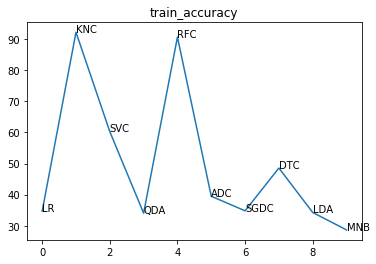

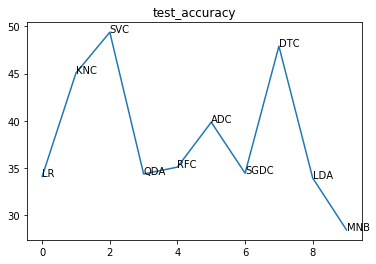

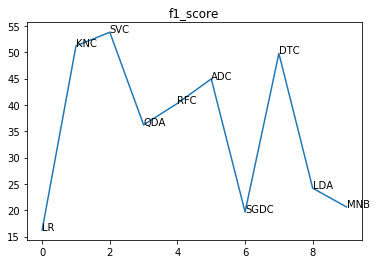

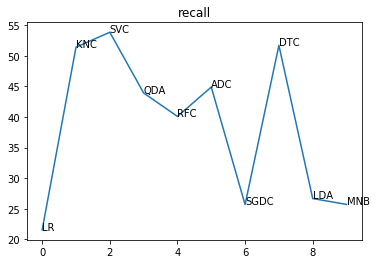

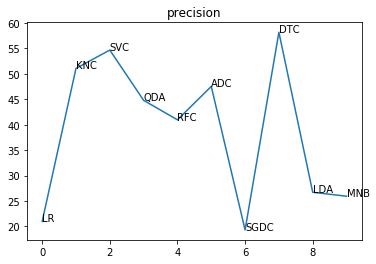

In [213]:
from matplotlib import pyplot as plt

titles = ['train_accuracy', 'test_accuracy', 'f1_score', 'recall', 'precision']

for i in xrange(len(eval_)):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    A = eval_[i][:]
    plt.title(titles[i])
    plt.plot(A)
    for j, label in enumerate(name):
        plt.text(j,A[j], label) 
    plt.show()

## Visualisations

We try to visualize the number of cases of disease outbreak in every state for all states of U.S.for a particular year given as an input in range **1960 - 2011**<br>



In [214]:
# using plotly for the beautiful plots 

import plotly.plotly as py
import plotly
import pandas as pd

# login api for plotly (dont forget to sign up to plotly)
plotly.tools.set_credentials_file(username= 'ab-bh', api_key ='*********')

In [217]:
# for UI

import pandas as pd 
import numpy as np
import plotly.offline as py

def get_viz(the_yr_data, yr):
    py.init_notebook_mode(connected=True)


    for col in the_yr_data.columns:
        the_yr_data[col] = the_yr_data[col].astype(str)

    scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
                [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]
    scl = [
            # Let first 10% (0.1) of the values have color rgb(0, 0, 0)
            [0, 'rgb(0, 0, 0)'],
            [0.1, 'rgb(0, 0, 0)'],

            # Let values between 10-20% of the min and max of z
            # have color rgb(20, 20, 20)
            [0.1, 'rgb(20, 20, 20)'],
            [0.2, 'rgb(20, 20, 20)'],

            # Values between 20-30% of the min and max of z
            # have color rgb(40, 40, 40)
            [0.2, 'rgb(40, 40, 40)'],
            [0.3, 'rgb(40, 40, 40)'],

            [0.3, 'rgb(60, 60, 60)'],
            [0.4, 'rgb(60, 60, 60)'],

            [0.4, 'rgb(80, 80, 80)'],
            [0.5, 'rgb(80, 80, 80)'],

            [0.5, 'rgb(100, 100, 100)'],
            [0.6, 'rgb(100, 100, 100)'],

            [0.6, 'rgb(120, 120, 120)'],
            [0.7, 'rgb(120, 120, 120)'],

            [0.7, 'rgb(140, 140, 140)'],
            [0.8, 'rgb(140, 140, 140)'],

            [0.8, 'rgb(160, 160, 160)'],
            [0.9, 'rgb(160, 160, 160)'],

            [0.9, 'rgb(180, 180, 180)'],
            [1.0, 'rgb(180, 180, 180)']
        ]
    data = [ dict(
            type='choropleth',
            colorscale = scl,
            autocolorscale = True,
            locations = the_yr_data['state'],
            z = the_yr_data['cases'].astype(float),
            zmin=0,
            zmax=500,
            locationmode = 'USA-states',
            text = the_yr_data['text'],
            marker = dict(
                line = dict (
                    color = 'rgb(255,255,255)',
                    width = 2
                )
            ),
            colorbar = dict(
                title = "Disease outbreak - cases in %d" %(yr)
            )
        ) ]

    layout = dict(
        title = '%d US Diseases Cases Found by State<br>(Hover for breakdown)' %(yr),
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
            ),
    )

    fig = dict( data=data, layout=layout )

    url = py.iplot( fig, validate=False)

def get_1yr_viz(yr):
    data = pd.read_csv('for_visulisation.csv')
    the_yr_data = data.loc[data['Year'] ==yr]
    from collections import defaultdict
    har = defaultdict(set)
    a = list(the_yr_data.state_name)
    b = list(the_yr_data.disease)
    #print len(a),len(b)
    for i in xrange(len(a)):
        har[a[i]].add(b[i])
    
    the_yr_data['disease_all'] = [' '.join(list(har[i])) for i in the_yr_data.state_name]
    
    the_yr_data['text'] = the_yr_data['state_name'] + '<br>' +\
    'Disease '+the_yr_data['disease_all']
    
    tf = the_yr_data.filter(['state_name','state','cases'], axis=1)
    tf.cases = tf.cases.astype(int)
    the_yr_data_2 = tf.groupby(['state_name','state']).sum().reset_index()
    the_yr_data_2['disease_all'] = [' '.join(list(har[i])) for i in the_yr_data_2.state_name]
    the_yr_data_2['text'] = the_yr_data_2['state_name'] + '<br>' +\
    'Disease '+the_yr_data_2['disease_all']
    
    get_viz(the_yr_data_2, yr)

In [218]:
# get visualization for year 2011

get_1yr_viz(2011)

In [219]:
# get visualization for year 1970 
get_1yr_viz(1970)